In [1]:
import pandas as pd

ames_housing = pd.read_csv("house_prices.csv", na_values="?")
# dropando a coluna "Id" que não tem poder nenhum preditivo
ames_housing = ames_housing.drop(columns="Id")
target_name = "SalePrice"
data, target = ames_housing.drop(columns=target_name), ames_housing[target_name]

Como podemos ver a variável target é numérica, portanto esse problema é um problema de regressão, iremos converter para um problema de classificação binária através da seguinte condição imposta:
* expensive(cara) para sale price --> $\gt 200,000$ USD.
* no expensive para sale price -->  $\le 200,000$ USD.

In [2]:
target = (target > 200_000).astype(int)
target

0       1
1       0
2       1
3       0
4       1
       ..
1455    0
1456    1
1457    1
1458    0
1459    0
Name: SalePrice, Length: 1460, dtype: int64

In [3]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
numerical_columns = data.select_dtypes(exclude=['object']).columns.to_list()
numerical_columns

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [6]:
print(f"O total de features numéricas é: {len(numerical_columns)}")

O total de features numéricas é: 36


## Criando um modelo preditivo com apenas as features numéricas
***

In [7]:
X = data[numerical_columns]
y = target

<AxesSubplot:>

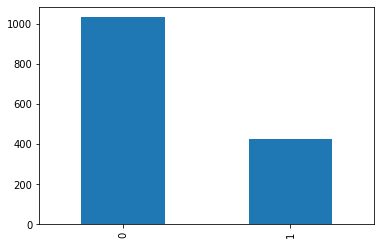

In [8]:
target.value_counts().plot.bar()

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
set_config(display='diagram')

In [10]:
numerical_preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

In [11]:
logistic_model = make_pipeline(
    numerical_preprocessor,
    LogisticRegression(max_iter=500)
)
logistic_model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median')),
                                 ('standardscaler', StandardScaler())])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [12]:
from sklearn.model_selection import cross_validate

In [13]:
%%time
cv_results = cross_validate(
    logistic_model, 
    X, y,
    cv = 5
)
scores = cv_results['test_score']
print(f"A média da acurácia no cross-validation é: {scores.mean():.3f} +/- {scores.std():.3f}")

A média da acurácia no cross-validation é: 0.921 +/- 0.014
CPU times: user 666 ms, sys: 483 ms, total: 1.15 s
Wall time: 339 ms


### Usando um pipeline que processa features numéricas e categóricas

In [14]:
categorical_columns = data.select_dtypes(include=['object']).columns
categorical_columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
categorical_preprocessor = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

numerical_preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessor = ColumnTransformer(transformers =[
    ("num_preprocessor", numerical_preprocessor, numerical_columns),
    ("cat_preprocessor", categorical_preprocessor, categorical_columns)
])

In [16]:
model = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=500)
)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_preprocessor',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [17]:
model.named_steps

{'columntransformer': ColumnTransformer(transformers=[('num_preprocessor',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  ['MSSubClass', 'LotFrontage', 'LotArea',
                                   'OverallQual', 'OverallCond', 'YearBuilt',
                                   'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                   'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                   '1stFlrSF', '2ndFlrSF', 'LowQualFinSF...
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Func

In [18]:
%%time
cv_results = cross_validate(
    model,
    data, target,
    cv = 5
)
scores = cv_results['test_score']
print(f"A média da acurácia no cross-validation é: {scores.mean():.3f} +/- {scores.std():.3f}")

A média da acurácia no cross-validation é: 0.924 +/- 0.010
CPU times: user 1.27 s, sys: 10.5 ms, total: 1.29 s
Wall time: 1.29 s


In [20]:
from sklearn.metrics import accuracy_score, classification_report
model.fit(data, target)
target_predicted = model.predict(data)
accuracy_score(target, target_predicted)

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.